# To-Dos: 

In [1]:
## Datensatz 'San Francisco Crime Classification' von Kaggle
## Datensatzbeschreibung:
# Datum                         - Zeitpunkt der Straftat
# Kategorie                     - Kategorie der Straftat (nur in Trainingsdaten), Zielvariable
# Beschreibung                  - detaillierte Beschreibung der Straftat (nur in Trainingsdaten)
# Tag der Woche
# 'District' der Polizeistation - Name des 'Districts' der Polizeistation
# Auflösung                     - Ergebniss der Straftat
# Adresse                       - geschätzte Adresse der Straftat
# X                             - Long
# Y                             - Lat

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [3]:
# Import der Pakete
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [4]:
# Einlesen der Trainings- und Testdaten
#train = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/train.csv")
#test  = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/test.csv")

In [5]:
# Pauls Kasten
#train = pd.read_csv("/content/drive/MyDrive/Uni/Master/2.Semester/DataMining/Data/train.csv")
#test  = pd.read_csv("/content/drive/MyDrive/Uni/Master/2.Semester/DataMining/Data/test.csv")

In [6]:
# Noah Kasten Lokal
#train = pd.read_csv(r'N:\FC_0_0_4\008_persoenliche_Arbeitsordner\Pannicke\Uni\Data Mining\data\train\train.csv')
#test = pd.read_csv(r"N:\FC_0_0_4\008_persoenliche_Arbeitsordner\Pannicke\Uni\Data Mining\data\test\test.csv")
train = pd.read_csv(r"C:\Users\nopa9\Documents\Universität\Master - HTW\2. Semester\DS\data\SF-Project\train.csv")
test = pd.read_csv(r"C:\Users\nopa9\Documents\Universität\Master - HTW\2. Semester\DS\data\SF-Project\test.csv")

In [7]:
# Übersicht über Kopf der Trainingsdaten
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [8]:
# Datentypen ermitteln
train.dtypes
# Bis auf die Koordinaten sind alle Variablen objects
# Datum muss umgewandlet werden in date

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [9]:
train.shape
# Datensatz hat rund 900k Zeilen und 9 Spalten

(878049, 9)

# **Datenvorverarbeitung**
- Trennung der Datenspalte
- NA Behandlung
- Duplikate entfernen
- Einschränkung der Kategorien

In [10]:
## Datenformatierung - Dates
# Umwandeln in Datumformat
train['Dates'] = pd.to_datetime(train['Dates'])
# Trennung von Datum und Uhrzeit
train['Date'] = train['Dates'].dt.strftime('%Y-%m-%d')
train['Date'] = pd.to_datetime(train['Date'])

train['Time'] = train['Dates'].dt.strftime('%H:%M')
train['Hour'] = pd.to_datetime(train['Dates'], format='%H:%M').dt.hour
train['Minute'] = pd.to_datetime(train['Dates'], format='%M').dt.minute

In [11]:
# Jahr, Monat, Tag extrahieren
train['Year']  = train['Dates'].dt.strftime('%Y').astype(int)
train['Month'] = train['Dates'].dt.strftime('%m').astype(int)
train['Day']   = train['Dates'].dt.strftime('%d').astype(int)
train['WeekdayName'] = train['Dates'].dt.strftime("%A")

In [12]:
# Variable WeekOfYear anlegen
train['WeekOfYear'] = pd.to_datetime(train['Date']).dt.isocalendar().week.astype(int)

In [13]:
## NA Behandlung
# Übersicht über NA in Spalten
train.isna().sum()
# keine NA's ersichtlich 

Dates          0
Category       0
Descript       0
DayOfWeek      0
PdDistrict     0
Resolution     0
Address        0
X              0
Y              0
Date           0
Time           0
Hour           0
Minute         0
Year           0
Month          0
Day            0
WeekdayName    0
WeekOfYear     0
dtype: int64

In [14]:
from shapely.geometry import  Point
import geopandas as gpd
#import geoplot as gplt
import shap
from sklearn.impute import SimpleImputer

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


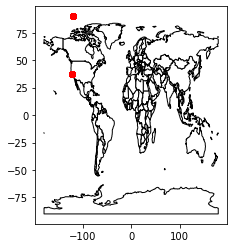

In [15]:
## Ausreißer, fehlerhafte Koordinaten 
# Lösung ist von Yannis Pappas (Kaggle)
# https://www.kaggle.com/code/yannisp/sf-crime-analysis-prediction
# Alternativlösungen benötigten kostenpflichtige geo API's

def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [16]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
train_gdf.loc[train_gdf.Y > 50].sample(5)

67


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Time,Hour,Minute,Year,Month,Day,WeekdayName,WeekOfYear,Coordinates
798834,2004-01-24 14:00:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Saturday,CENTRAL,NONE,GREENWICH ST / THE EMBARCADERO NORTH ST,-120.5,90.0,2004-01-24,14:00,14,0,2004,1,24,Saturday,4,POINT (-120.50000 90.00000)
842261,2003-06-25 07:30:00,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Wednesday,RICHMOND,NONE,JOHN F KENNEDY DR / MARTIN LUTHER KING JR DR,-120.5,90.0,2003-06-25,07:30,7,30,2003,6,25,Wednesday,26,POINT (-120.50000 90.00000)
674043,2005-10-21 10:15:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90.0,2005-10-21,10:15,10,15,2005,10,21,Friday,42,POINT (-120.50000 90.00000)
687527,2005-08-13 17:00:00,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Saturday,TENDERLOIN,NONE,JENNINGS CT / INGALLS ST,-120.5,90.0,2005-08-13,17:00,17,0,2005,8,13,Saturday,32,POINT (-120.50000 90.00000)
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0,2005-12-30,17:00,17,0,2005,12,30,Friday,52,POINT (-120.50000 90.00000)


'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


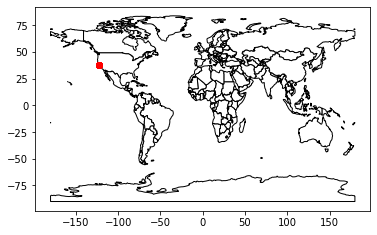

In [17]:
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])

train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()
# Ausreißer bei den Korrdinaten wurde mittels Weltkarte bestimmmt. Verschiebung auf y-Axse ersichtlich. Ersetzen der Koordinaten mit den durchschnittlichen Koordinaten des Polizei Distrikts.  

In [18]:
## Übersicht über Mengengerüst der Daten
# Ausgabe eindeutiger Werte für relevanten Spalten
train_uniq = train.loc[:,['Category','PdDistrict','Resolution','Address']]
for col in train_uniq:
  print(train_uniq[col].value_counts())

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

In [19]:
# Augenscheinlich keine fehlerhaften/uneindeutige Werte enthalten
# Bei Addresse sollte per Feature Importance die Relevanz für das Modell ermittelt werden,
# bevor man den Umfang an Werten genauer auf Fehler analysiert.

In [20]:
## Duplikate
# Anzahl der Duplikate
dup_rows = train.duplicated()
print('Anzahl an duplizierten Zeilen:',sum(dup_rows))

Anzahl an duplizierten Zeilen: 0


In [21]:
# Entfernen der Duplikate
train        = train.drop_duplicates()
dup_rows_new = train.duplicated()
print('Anzahl an duplizierten Zeilen:',sum(dup_rows_new))

Anzahl an duplizierten Zeilen: 0


In [22]:
# Entfernen von nicht nutzbaren Variablen 
train.drop(['Descript'],axis=1)

,Dates,Category,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,Time,Hour,Minute,Year,Month,Day,WeekdayName,WeekOfYear
0,2015-05-13 23:53:00,WARRANTS,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23:53,23,53,2015,5,13,Wednesday,20
1,2015-05-13 23:53:00,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,23:53,23,53,2015,5,13,Wednesday,20
2,2015-05-13 23:33:00,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13,23:33,23,33,2015,5,13,Wednesday,20
3,2015-05-13 23:30:00,LARCENY/THEFT,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13,23:30,23,30,2015,5,13,Wednesday,20
4,2015-05-13 23:30:00,LARCENY/THEFT,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13,23:30,23,30,2015,5,13,Wednesday,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003-01-06,00:15,0,15,2003,1,6,Monday,2
878045,2003-01-06 00:01:00,LARCENY/THEFT,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,2003-01-06,00:01,0,1,2003,1,6,Monday,2
878046,2003-01-06 00:01:00,LARCENY/THEFT,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,2003-01-06,00:01,0,1,2003,1,6,Monday,2
878047,2003-01-06 00:01:00,VANDALISM,Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003-01-06,00:01,0,1,2003,1,6,Monday,2


# **Feature Engineering**

In [23]:
#Sonnenauf -und untergänge in San Francisco auf monatlicher Basis
#sunset = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/SunsetSF.csv",delimiter =';')
#sunset['Month']=sunset['Month'].astype(int)

In [24]:
# Sonnenauf- und untergang auf täglcher Basis
sunset = pd.read_csv(r"C:\Users\nopa9\Documents\Universität\Master - HTW\2. Semester\DS\data\SF-Project\SunsetSF.csv",sep=';')
sunset['Month']=sunset['Month'].astype(int)
sunset['Day']=sunset['Day'].astype(int)

In [25]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## 1. Feature - Tat zur Tageszeit
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sunset.dtypes

Month     int32
Day       int32
Rise     object
Set      object
dtype: object

In [26]:
train = pd.merge(train,sunset[['Month','Day','Rise','Set']],how='left',on=['Month','Day'])

In [27]:
# Funktion zur Bestimmung ob Zeit der Tat zwischen Sonnenaufgang und Sonnenuntergag lag
def is_between(time, time_range):
    if time_range[1] < time_range[0]:
        return time >= time_range[0] | time <= time_range[1]
    return time_range[0] <= time <= time_range[1]

train['CrimeAtDayTime'] = train.apply(lambda row: is_between(row['Time'],(row['Rise'],row['Set'])),axis=1)  

In [28]:
#%%%%%%%%%%%%%%%%%%%%%%%%%
## 2. Feature - Wochenende
#%%%%%%%%%%%%%%%%%%%%%%%%%
train['DayOfWeek'] = train['Date'].dt.dayofweek
# Beginned bei 0 = Monday
train['IsWeekend'] = train['Date'].dt.dayofweek > 4

In [29]:
#%%%%%%%%%%%%%%%%%%%%%%%
## 3. Feature - Feiertag
#%%%%%%%%%%%%%%%%%%%%%%%
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
print(min(train['Date']))
print(max(train['Date']))
holidays = cal.holidays(start='2003-01-01', end='2015-12-31').to_pydatetime()

2003-01-06 00:00:00
2015-05-13 00:00:00


In [30]:
train['IsHoliday'] = np.where(train['Date'].isin(holidays),True,False)

In [31]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## 4. Feature - Stoßzeiten Verkehr
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Stoßzeiten SF: 7-9 AM, 4:30-6:30 PM
# https://sfgov.org/scorecards/transportation/congestion#:~:text=The%20AM%20peak%20period%20is,representative%20of%20overall%20traffic%20conditions.
train['RushHour'] = train.apply(lambda row: is_between(row['Time'],('07:00','09:00')),axis=1)  
train['RushHour'] = train.apply(lambda row: is_between(row['Time'],('16:30','18:30')),axis=1)  

In [32]:
## Datenformatierung - Category
# Entfernen von nicht benötigten Kategorien
train['Category'].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [33]:
# Filtern auf benötigte Kategorien
imp_cat   = ['LARCENY/THEFT','ASSAULT','DRUG/NARCOTIC','VEHICLE THEFT','BURGLARY']
train_sub = train[train['Category'].isin(imp_cat)]

In [34]:
train_sub['Category'].unique()

array(['LARCENY/THEFT', 'VEHICLE THEFT', 'ASSAULT', 'BURGLARY',
       'DRUG/NARCOTIC'], dtype=object)

# **Deskriptive Analyse**


In [35]:
train.loc[:, ~train.columns.isin(['CrimeAtDayTime','IsWeekend','IsHoliday','RushHour'])].corr()

,DayOfWeek,X,Y,Hour,Minute,Year,Month,Day,WeekOfYear
DayOfWeek,1.000000,0.008242,0.013497,-0.021014,-0.014083,0.014135,0.010766,0.010622,0.004083
X,0.008242,1.000000,0.154145,0.002283,0.057882,0.002211,-0.000207,0.002132,0.000307
Y,0.013497,0.154145,1.000000,-0.010811,0.013609,0.024385,0.003933,0.004174,0.003533
Hour,-0.021014,0.002283,-0.010811,1.000000,0.010104,-0.006266,-0.001786,0.015512,-0.005847
Minute,-0.014083,0.057882,0.013609,0.010104,1.000000,0.019276,-0.008210,0.009680,-0.010174
Year,0.014135,0.002211,0.024385,-0.006266,0.019276,1.000000,-0.048262,-0.009961,-0.047987
Month,0.010766,-0.000207,0.003933,-0.001786,-0.008210,-0.048262,1.000000,0.016912,0.983152
Day,0.010622,0.002132,0.004174,0.015512,0.009680,-0.009961,0.016912,1.000000,0.086318
WeekOfYear,0.004083,0.000307,0.003533,-0.005847,-0.010174,-0.047987,0.983152,0.086318,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

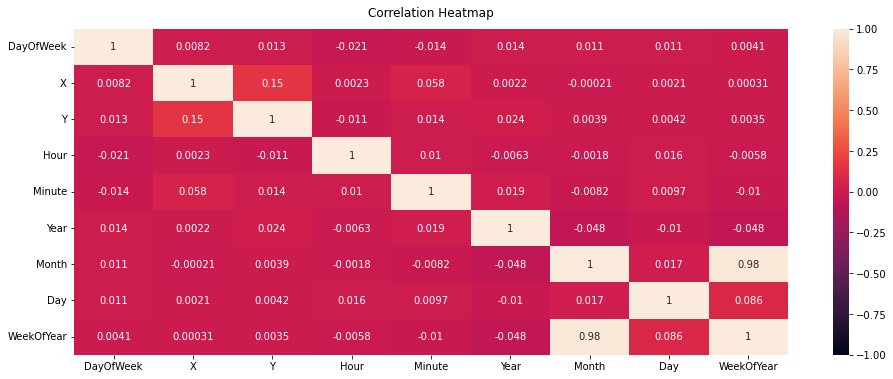

In [36]:
## Korrelationsanalyse Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train.loc[:, ~train.columns.isin(['CrimeAtDayTime','IsWeekend','IsHoliday','RushHour'])].corr(), vmin=-1,vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
# Keine Korrelation ersichtlich, welche nicht erklärbar ist. Kein entfernen von Merkmalen notwendig.

In [37]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

train_cat = train[['Category','PdDistrict','Resolution','CrimeAtDayTime','IsWeekend','IsHoliday','RushHour']]

Korrelationsanalyse von kategorialen Merkmalen, mittels Cramers V.

In [38]:
rows= []

for var1 in train_cat:
  col = []
  for var2 in train_cat :
    cramers =cramers_V(train_cat[var1], train_cat[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = train_cat.columns, index =train_cat.columns)
df
# Es sind keine Abhängigkeiten ziwschen den kategorialen Merkmalen ersichtlich.

,Category,PdDistrict,Resolution,CrimeAtDayTime,IsWeekend,IsHoliday,RushHour
Category,1.00,0.02,0.09,0.02,0.00,0.00,0.00
PdDistrict,0.02,1.00,0.01,0.00,0.00,0.00,0.00
Resolution,0.09,0.01,1.00,0.00,0.00,0.00,0.00
CrimeAtDayTime,0.02,0.00,0.00,1.00,0.00,0.00,0.03
IsWeekend,0.00,0.00,0.00,0.00,1.00,0.01,0.00
IsHoliday,0.00,0.00,0.00,0.00,0.01,1.00,0.00
RushHour,0.00,0.00,0.00,0.03,0.00,0.00,1.00


In [39]:
## Density Plot Anzahl Straftaten pro Tag
crimes_per_date = train.groupby('Date').count().iloc[:,0]

In [40]:
def density_plot(data):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    for ax in axes:
        sns.kdeplot(data, shade=False, color='crimson', ax=ax)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        if ax == axes[0]:
            middle = data.mean()
            sdev = data.std()
            left = middle - sdev
            right = middle + sdev
            ax.set_title('Mittelwert und Standardabweichung')
        else:
            left, middle, right = np.percentile(data, [25, 50, 75])
            ax.set_title('Mittelwert und Quartile')
        ax.vlines(middle, 0, np.interp(middle, xs, ys), color='crimson', ls=':')
        ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
        ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
        ax.set(xlabel='Anzahl Straftaten pro Tag')
    plt.show()



`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.



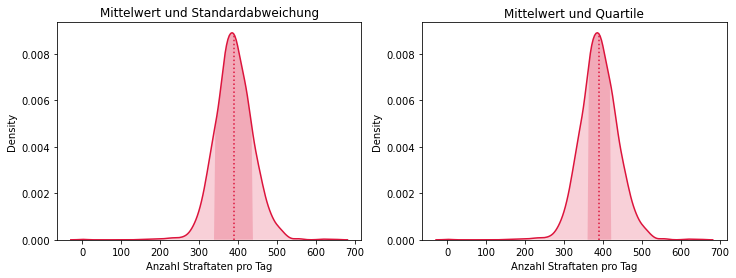

In [41]:
## Density Plot Anzahl Straftagen pro Tag mit Mittelwer, Standardabweichung und Qunatile
density_plot(data = crimes_per_date)
# Die Durchschnittliche Anzahl an Straftagen liegt bei ca. 400 pro Tag. 

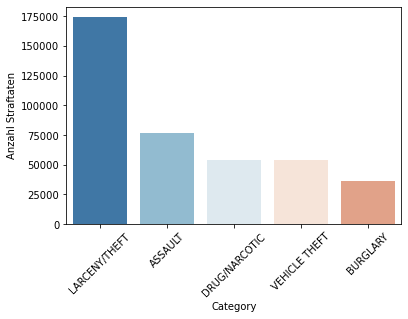

In [42]:
## Verteilung Straftaten
sns.set_palette('RdBu_r')
sns.countplot(x='Category',
              data=train_sub,
              order = train_sub['Category'].value_counts().index)
plt.ylabel('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()

In [43]:
## Verteilung der Straftaten Relativ
cat_rel = train_sub.Category.value_counts(normalize=True)
cat_rel = cat_rel.mul(100)
cat_rel = cat_rel.rename('percent').reset_index()

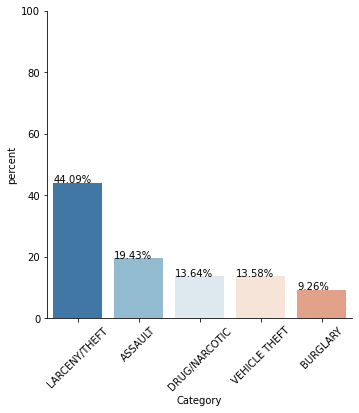

In [44]:
sns.set_palette('RdBu_r')
g = sns.catplot(x = 'index',
                y = 'percent',
                kind = 'bar',
                order = train_sub['Category'].value_counts().index,
                data = cat_rel)
g.ax.set_ylim(0,100)
g.set(xlabel = 'Category')
plt.xticks(rotation=45)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
# Fast die Hälfte aller aufgezeichneten Straftaten stehen mit Diebstahl im Zusammenhang, gefolgt von Körperverletzung, welche rund 1/5 der Straftaten ausmacht. Am seltensten wurde Einbruch begangen.

In [45]:
## Funktion zur Erzeugung gruppierter Plots mit relativem Anteil
def Grouped_Rel_Plot(group_by, split, length = 1):
    day_night = train_sub.groupby(group_by)[split].value_counts(normalize=True)
    day_night = day_night.mul(100)
    day_night = day_night.rename('percent').reset_index()
    
    sns.set_palette('RdBu_r')
    g = sns.catplot(x = group_by,
                    y = 'percent',
                    hue = split,
                    kind = 'bar',
                    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'] if (group_by == 'WeekdayName') else train_sub[group_by].value_counts().index,
                    aspect = length,
                    data = day_night)
    g.ax.set_ylim(0,100)
    g.set(xlabel = group_by)
    plt.xticks(rotation = 45)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

In [46]:
## Funktion zur Erzeugung gruppierter Plots mit relativem Anteil ohne HUE Parameter
def Grouped_Plot(group_by, length = 1):
    day_night = train_sub[group_by].value_counts(normalize=True)
    day_night = day_night.mul(100)
    day_night = day_night.rename('percent').reset_index()
    
    sns.set_palette('RdBu_r')
    g = sns.catplot(x = 'index',
                    y = 'percent',
                    kind = 'bar',
                    order = train_sub[group_by].value_counts().index,
                    aspect = length,
                    data = day_night)
    g.ax.set_ylim(0,100)
    g.set(xlabel = group_by)
    plt.xticks(rotation = 45)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

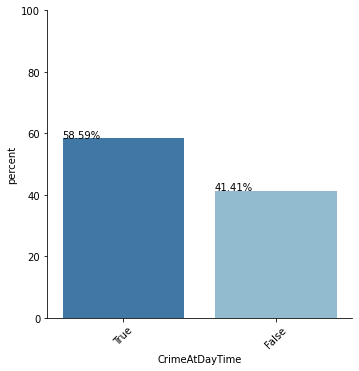

In [47]:
## Verteilung der Straftaten auf Tages- bzw. Nachtzeit
Grouped_Plot(group_by = 'CrimeAtDayTime', length=1)
# Fast 60% der Straftaten fanden zur Tageszeit statt.

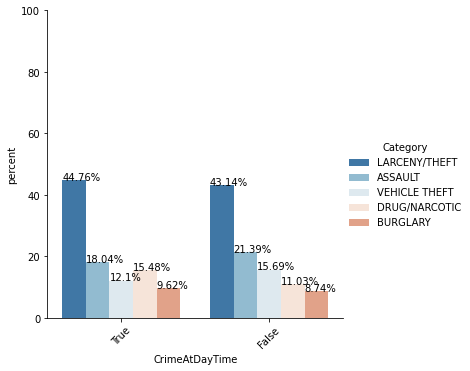

In [48]:
## Relativer Anteil der Kategorien, zu Tages- bzw. Nachtzeit
Grouped_Rel_Plot(group_by = 'CrimeAtDayTime', split = 'Category')
# Zur Tageszeit werden mehr Straftaten im Zusammenhang mit Drogen erfasst. Zur Nachtzeit wiederrum mehr Taten der Körperverletzung und Wagendiebstahl.

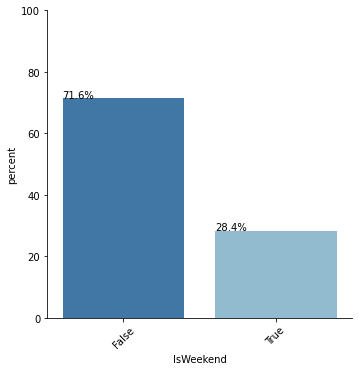

In [49]:
## Verteilung der Straftaten auf Wochenende bzw. Werktags
Grouped_Plot(group_by = 'IsWeekend', length=1)
# Anzahl der Straftaten am Wochenden als auch innerhalb der Woche vergleichbar.

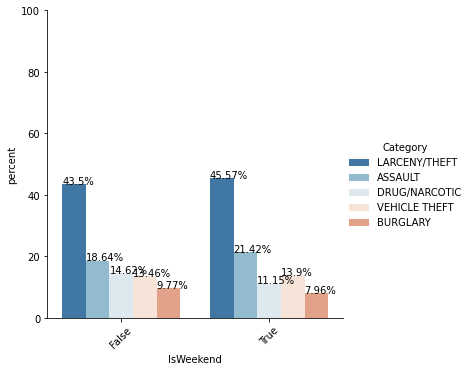

In [50]:
## Relativer Anteil der Kategorien, Werktags und Wochenende
Grouped_Rel_Plot(group_by = 'IsWeekend', split = 'Category')
# Straftaten im Zusammenhang mit Diebstahl und Körperverletzung kommen häufiger am Wochende vor.
# Innerhalb der Woche erfolgen mehr Drogenstraftaten und Einbrüche.

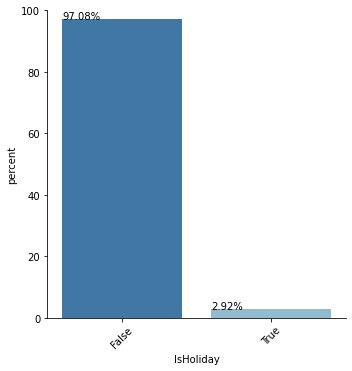

In [51]:
## Verteilung der Straftaten auf Feiertag bzw. Nicht-Feiertag
Grouped_Plot(group_by = 'IsHoliday', length=1)
# Rund 3% der aufgezeichneten Straftaten erfolgten an Feiertagen.

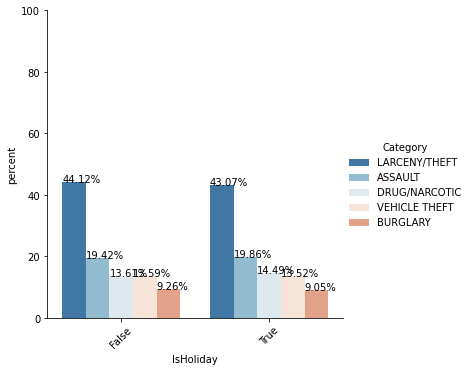

In [52]:
## Relativer Anteil der Kategorien, Feiertags und Nicht-Feiertags
Grouped_Rel_Plot(group_by = 'IsHoliday', split = 'Category')
# Nahezu identische Verteilung, leichte Abweichung in Diebstahl und Betäubungsmittel.



`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.



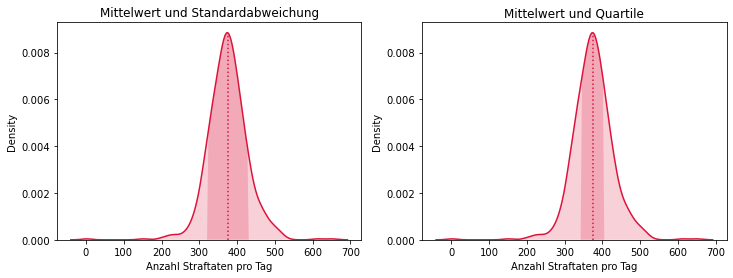

In [53]:
## Durchschnittliche Anzahl an Straftaten an freien Tagen (Wochende oder Feiertag)
crimes_free_day = train.query('IsWeekend == True | IsHoliday == True').groupby('Date').count().iloc[:,0]
density_plot(crimes_free_day)



`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.



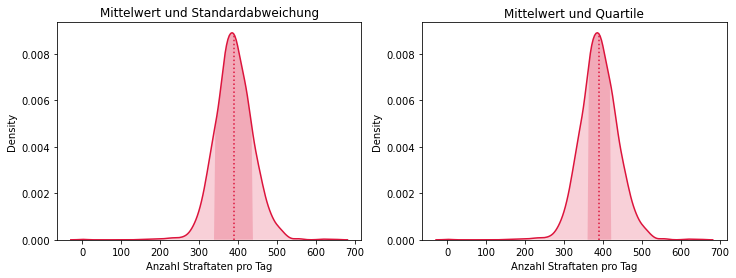

In [54]:
## Durchschnittliche Anzahl an Straftaten an Werktagen (Wochende oder Feiertag)
crimes_work_day = train.query('IsWeekend == False | IsHoliday == False').groupby('Date').count().iloc[:,0]
density_plot(crimes_work_day)
# Es ist erkennbar, dass die durchschnittliche Anzahl an Straftaten pro Tag an Werktagen leicht über dem Durchschnitt an Wochenend- und Feiertagen liegt.

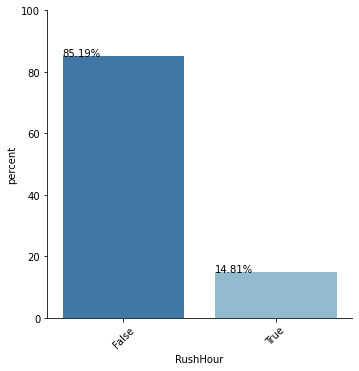

In [55]:
## Verteilung der Straftaten auf Stoßzeiten im Verkehr 
Grouped_Plot(group_by = 'RushHour', length=1)
# Rund 15% der Straftaten wurden zu Stoßzeiten begangen.

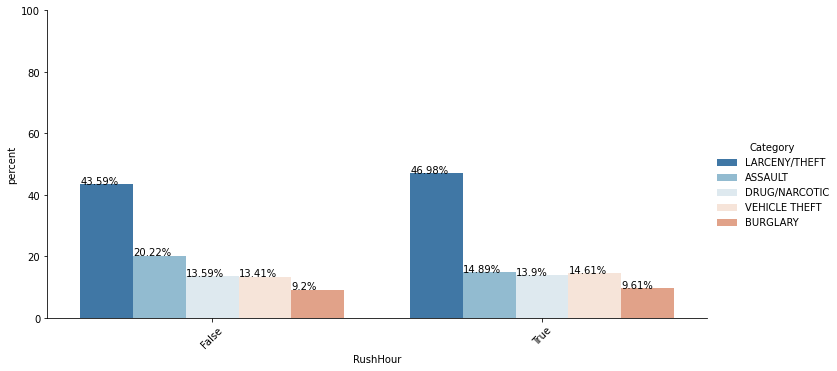

In [56]:
## Relativer Anteil der Kategorien, zu und außerhalb von Stoßzeiten im Verkehr
Grouped_Rel_Plot(group_by = 'RushHour', split = 'Category', length=2)
# Zu Stoßzeiten wurden deutlich weniger Straftaten hinsichtlich Körperverletzung aufgezeichnet. Gleichzeitig kommt es zu einem leichten Anstieg von Diebstählen.

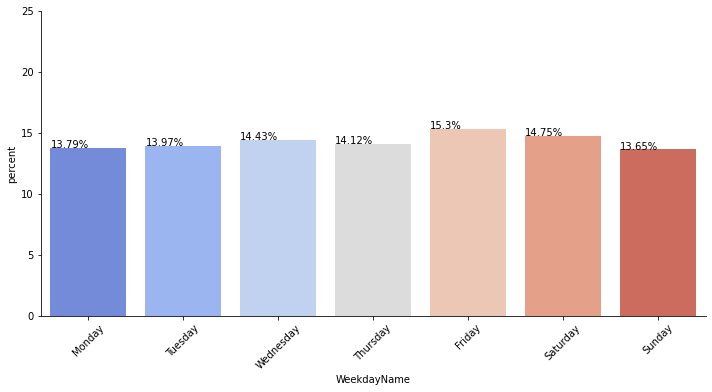

In [57]:
## Verteilung der Straftaten auf Wochentage
from matplotlib import cm
day_night = train_sub['WeekdayName'].value_counts(normalize=True)
day_night = day_night.mul(100)
day_night = day_night.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])
day_night = day_night.rename('percent').reset_index()

#sns.color_palette("rocket", as_cmap=True)
g = sns.catplot(x = 'index',
                y = 'percent',
                kind = 'bar',
                #order = train_sub['index'].value_counts().index,
                aspect = 2,
                palette=sns.color_palette('coolwarm', n_colors=7),
                data = day_night)
g.ax.set_ylim(0,25)
g.set(xlabel = 'WeekdayName')
plt.xticks(rotation = 45)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    # Es wird ein Peak von Straftaten am Freitag ersichtlich.
    # Am wenigsten werden Straftaten am Sonntag begangen.

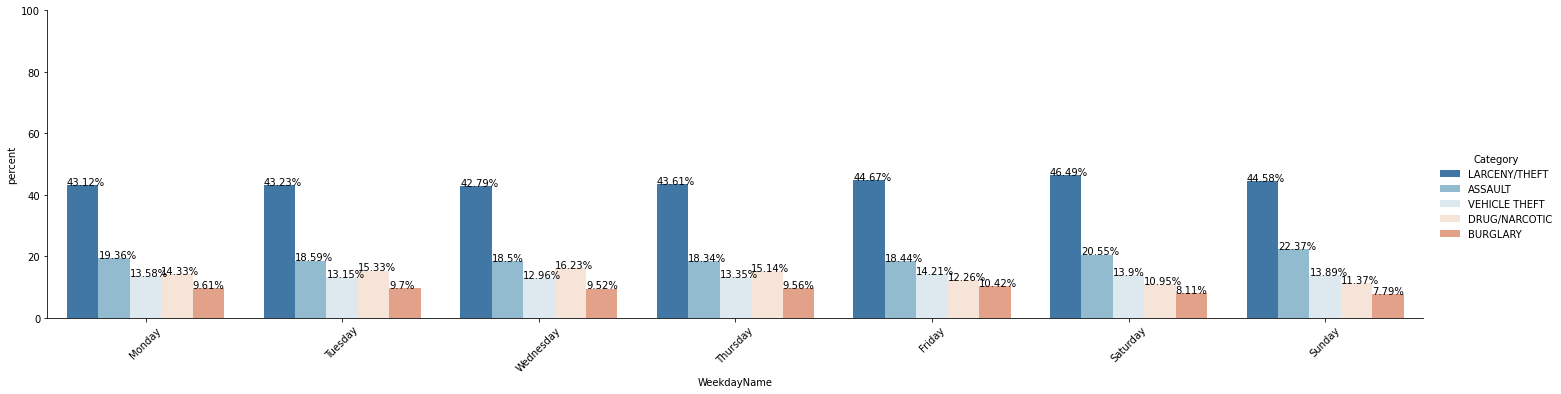

In [58]:
## Relativer Anteil der Kategorien, nach Wochentagen
Grouped_Rel_Plot(group_by = 'WeekdayName', split = 'Category',length=4)
# Auffälligkeiten am Wochenende bereits beschrieben.

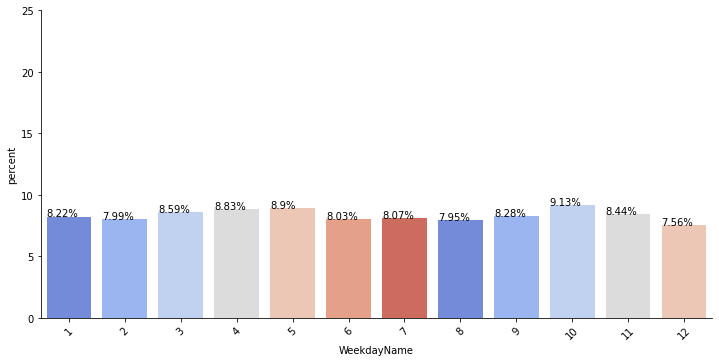

In [59]:
## Verteilung der Straftaten auf die Monate
from matplotlib import cm
day_night = train_sub['Month'].value_counts(normalize=True)
day_night = day_night.mul(100)
day_night = day_night.rename('percent').reset_index()

#sns.color_palette("rocket", as_cmap=True)
g = sns.catplot(x = 'index',
                y = 'percent',
                kind = 'bar',
                #order = train_sub['index'].value_counts().index,
                aspect = 2,
                palette=sns.color_palette('coolwarm', n_colors=7),
                data = day_night)
g.ax.set_ylim(0,25)
g.set(xlabel = 'WeekdayName')
plt.xticks(rotation = 45)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    # Alle Monate habe ungefähr vergelichbar viele Straftaten mit geringen Wellen im April/Mai und Oktober.
    # Die wenigsten Straftaten weißt der Dezember auf und die meisten der Oktober.

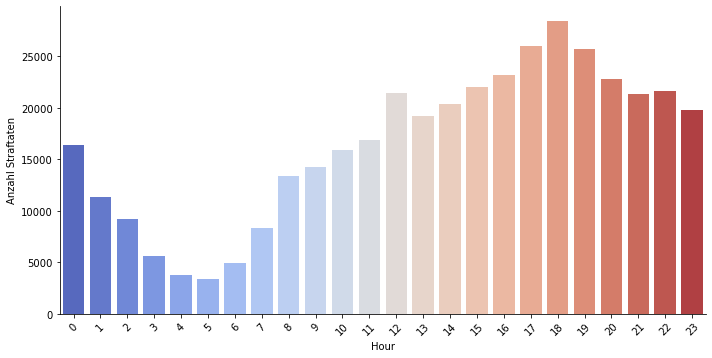

In [60]:
## Anzahl der Straftaten je Stunde
sns.set_palette('RdBu_r')
k = sns.catplot(x = 'Hour',
            data = train_sub,
                aspect = 2,
                palette=sns.color_palette('coolwarm', n_colors=24),
            kind = 'count')
k.set_ylabels('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()
# Auffälligkeit: Zu 12 und 18 Uhr sind Ausreißer ersichtlich. Auch 22 Uhr übersteigt die Stunde davor.
# Ggf. liegt dort ein systematsicher Erfassungsfehler vor.

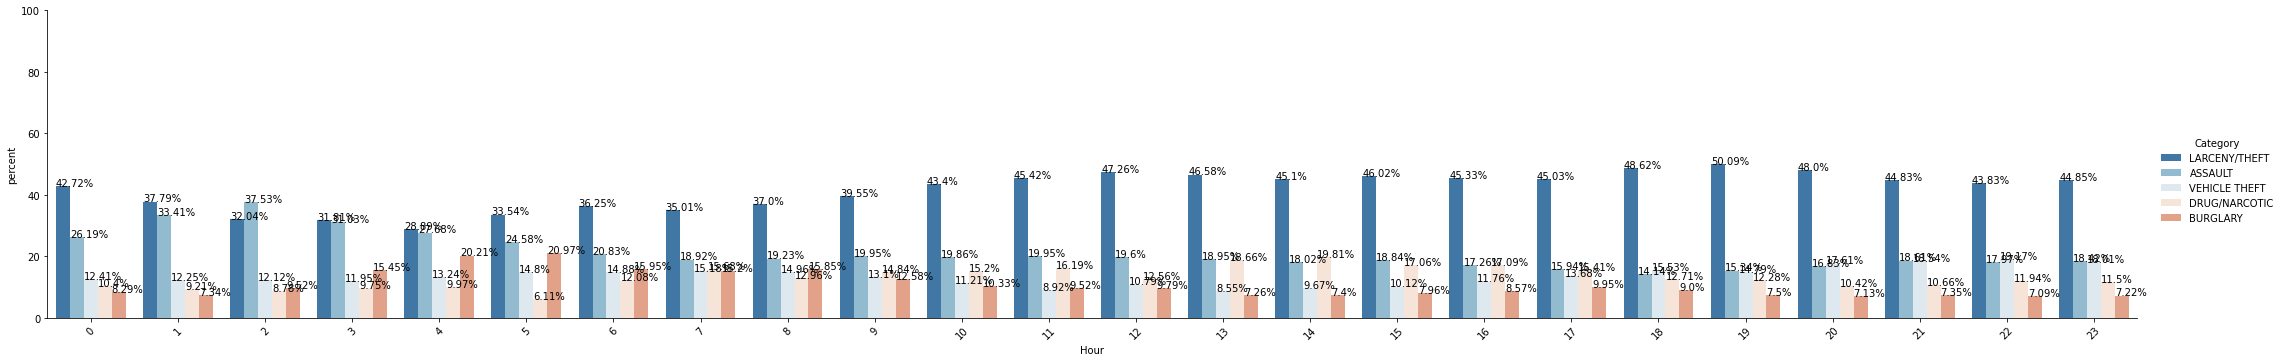

In [61]:
## Darstellung noch zu ungenau, wrid auf einzelne Plots für jede Kategorie umgebaut!
day_night = train_sub.groupby('Hour')['Category'].value_counts(normalize=True)
day_night = day_night.mul(100)
day_night = day_night.rename('percent').reset_index()

sns.set_palette('RdBu_r')
g = sns.catplot(x = 'Hour',
                y = 'percent',
                hue = 'Category',
                kind = 'bar',
                aspect = 6,
                data = day_night)
g.ax.set_ylim(0,100)
g.set(xlabel = 'Hour')
plt.xticks(rotation = 45)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

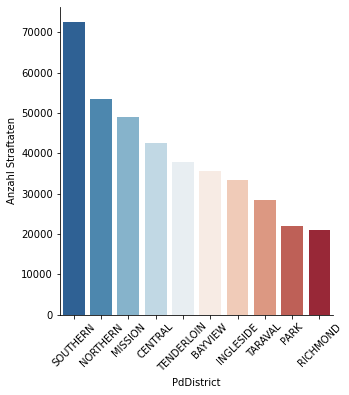

In [62]:
## Anzahl der Straftaten je Revier
k = sns.catplot(x = 'PdDistrict',
            data = train_sub,
            order = train_sub['PdDistrict'].value_counts().index,
            palette=sns.color_palette('RdBu_r', n_colors=10),
            kind = 'count')
k.set_ylabels('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()

In [63]:
## Verteilung der Straftaten je Revier
pddis_rel = train_sub.PdDistrict.value_counts(normalize=True)
pddis_rel = pddis_rel.mul(100)
pddis_rel = pddis_rel.rename('percent').reset_index()

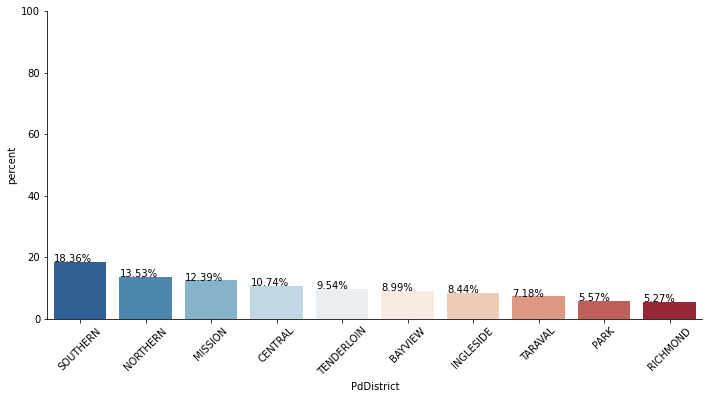

In [64]:
sns.color_palette('RdBu_r')
g = sns.catplot(x='index',
                y='percent',
                kind='bar',
                palette=sns.color_palette('RdBu_r', n_colors=10),
                data=pddis_rel,
                aspect=2)
g.ax.set_ylim(0,100)
g.set(xlabel='PdDistrict')
plt.xticks(rotation=45)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    # Meisten Straftaten erfolgen in Southern, gefolgt von Northern. Die wenigsten Straftaten wurden in Park und Rochmond erfasst.
    # Southern tedenziell Struktur schwächer.

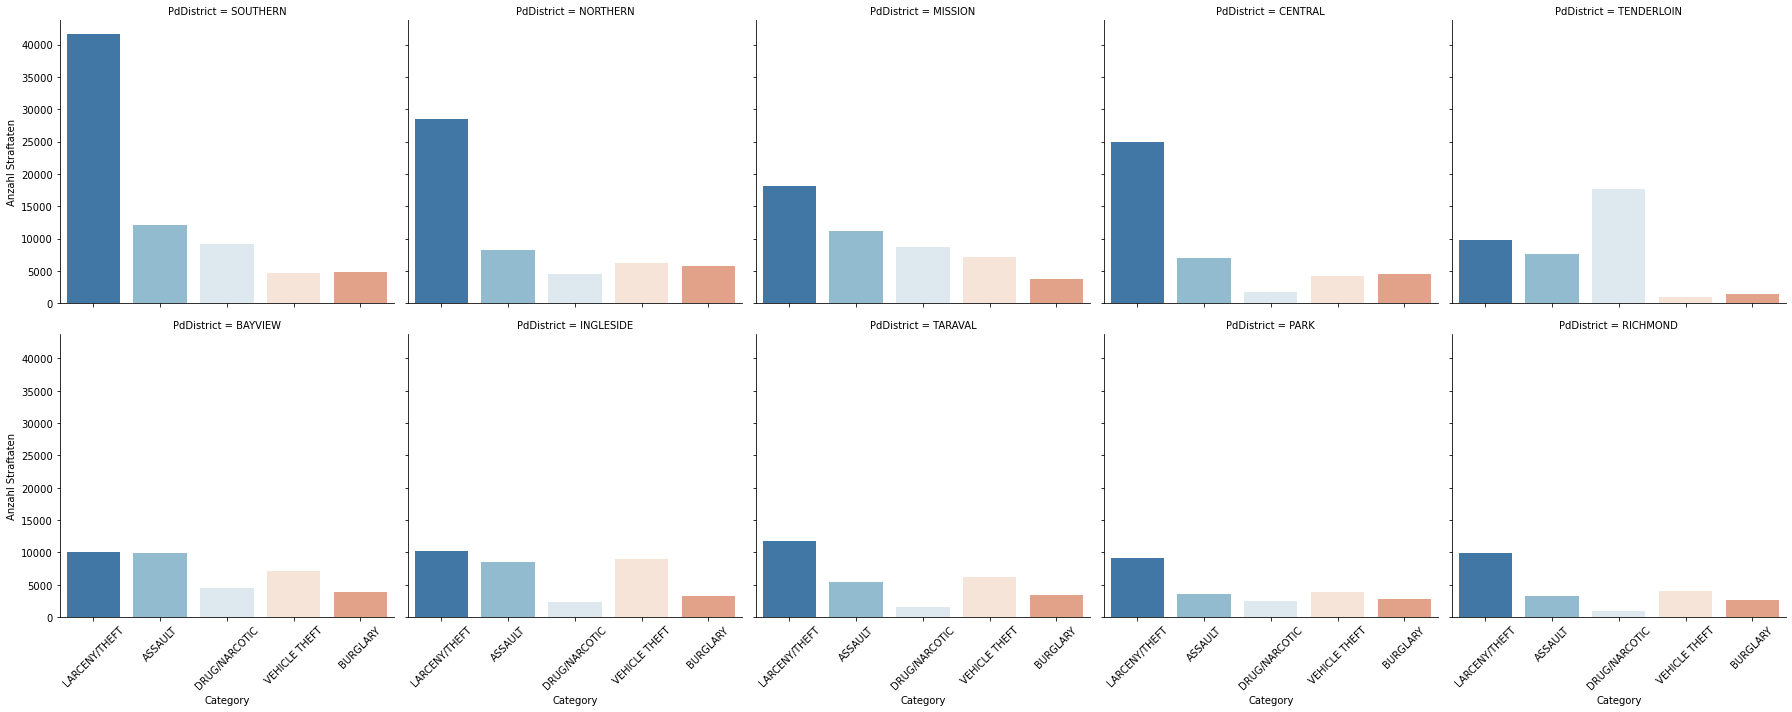

In [65]:
## Verteilung der Straftatsarten je Revier
g = sns.catplot(x='Category',
              data=train_sub,
            kind='count',
              order = train_sub['Category'].value_counts().index,
            col='PdDistrict',
            col_wrap=5,
            col_order=train_sub['PdDistrict'].value_counts().index)
g.set_ylabels('Anzahl Straftaten')
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
g.tight_layout()
plt.show()
# Auffälligkeiten: 
# 9 von 10 PdDistricts ist Diebstahl die häufigste Straftat.
# Tenderloin besitzt Ausreißer bei Straftaten mit Drogen.
# Aufgrund fehlender Einwohnerdaten pro PdDistrict kann diese Darstellung nicht in relativ zur Einwohnerdichte abgebildet werden.

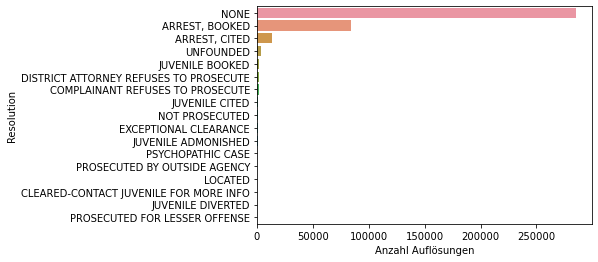

In [66]:
########################## Nicht relevant da Merkmal entfernt wird ###########################
## Verteilung Auflösungen
sns.color_palette('RdBu_r')
sns.countplot(y='Resolution',
              data=train_sub,
              order = train_sub['Resolution'].value_counts().index)
plt.xlabel('Anzahl Auflösungen')
#plt.xticks(rotation=90)
plt.show()
# Dieses Merkmal kann ggf. entfernt werden, aufgrund der vielen NONE Einträge

In [67]:
## Zusammenführen der geringen Resolution Ausprägungen
top_res = train_sub.groupby(['Resolution']).size().reset_index(name='counts')
top_res = top_res.sort_values(by='counts',ascending=False)
top_res_names = top_res.iloc[0:4,0].tolist()
top_res_names

['NONE', 'ARREST, BOOKED', 'ARREST, CITED', 'UNFOUNDED']

In [68]:
## Alle Ausprägungen mit geringer Anzahl werden zusammengefasst
train_sub_red = train_sub
train_sub_red['Resolution'].mask(~train_sub_red['Resolution'].isin(top_res_names), 'OTHER', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
train_sub_red.groupby('Resolution').size()

Resolution
ARREST, BOOKED     83907
ARREST, CITED      13426
NONE              285260
OTHER               9155
UNFOUNDED           3612
dtype: int64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'LARCENY/THEFT'),
  Text(1, 0, 'VEHICLE THEFT'),
  Text(2, 0, 'ASSAULT'),
  Text(3, 0, 'BURGLARY'),
  Text(4, 0, 'DRUG/NARCOTIC')])

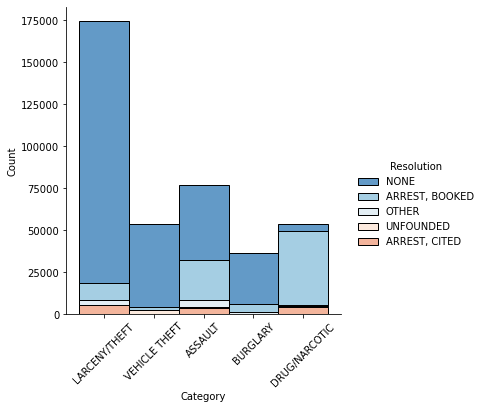

In [70]:
sns.color_palette('RdBu_r')
sns.displot(train_sub, x='Category', hue='Resolution', multiple='stack')
plt.xticks(rotation=45)
# Großteil der Straftaten werden nicht aufgelöst.
# Besonders Körperverletzung und Straftaten mit Drogen enden häufig in einer Verhaftung.

Modelltraining

In [71]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [72]:
train_sub.dtypes
# XGBoost kann nur numerische Variablen verarbeiten - Umformung einiger Variablen notwendig

Dates             datetime64[ns]
Category                  object
Descript                  object
DayOfWeek                  int64
PdDistrict                object
Resolution                object
Address                   object
X                        float64
Y                        float64
Date              datetime64[ns]
Time                      object
Hour                       int64
Minute                     int64
Year                       int32
Month                      int32
Day                        int32
WeekdayName               object
WeekOfYear                 int32
Rise                      object
Set                       object
CrimeAtDayTime              bool
IsWeekend                   bool
IsHoliday                   bool
RushHour                    bool
dtype: object

In [73]:
## Subset für XGBoost Modell
train_xg = train_sub

In [74]:
## Entfernen von Spalten ohne Informationsgehalt oder 'data leakage'
train_xg = train_xg.drop(['Descript','Resolution','Rise','Set','Address','Time','Dates','WeekdayName','Dates','Date'],axis=1)
# Encoding von Addresse aufgrund hoher Dimensionalität und Multiclass Prediction nicht möglich

In [75]:
## Trennen von Target
X = train_xg.drop(['Category'],axis=1)

In [76]:
## One-Hot-Encoding für PdDistrict und WeekdayName
#def encode_and_bind(original_dataframe, feature_to_encode):
#    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
#    res = pd.concat([original_dataframe, dummies], axis=1)
#    res = res.drop([feature_to_encode], axis=1)
#    return(res)

#features_to_encode = ['WeekdayName', 'PdDistrict']
#for feature in features_to_encode:
#    res = encode_and_bind(X, feature)

In [77]:
# Encoding the Categorical Variables
le1 = LabelEncoder()
X['PdDistrict'] = le1.fit_transform(X['PdDistrict'])

le2 = LabelEncoder()
y = le2.fit_transform(train_xg['Category'])

In [98]:
# HP Definition für HPO mittels CV
params = {"objective":["multi:softprob"],
          'colsample_bytree': [0.3,0.5,0.7],
          'learning_rate': [0.03,0.05,0.1],
          'max_depth': [5,7,10],
          'n_estimators': [5,50,100],          
          'min_child_weight': [5,11,20]}

xgb_model = xgb.XGBClassifier()

In [99]:
# Kreuzvalidierung mit GridSearchCV
from xgboost import cv
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, RandomizedSearchCV
#kfold = StratifiedGroupKFold(n_splits=5, shuffle=False).split(X, y, groups=groups[y])
clf = GridSearchCV(xgb_model, params, n_jobs=-1, 
                   cv = StratifiedKFold(n_splits=5, shuffle=False), 
                   scoring='f1_micro',
                   verbose=2, refit=True)



rlf = RandomizedSearchCV(xgb_model, params,
                                  cv=StratifiedKFold(n_splits=5, shuffle=False),
                                  n_iter=10, scoring='f1_micro',
                                  verbose=5,
                                  n_jobs=-1)


In [100]:
clf.fit(X,y)
rlf.fit(X,y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           int...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7],
                                        'learning_rate': [0.03, 0.05, 0.1],
                                        'max_depth': [5, 7, 10],
                                        'min_child_weight': [5, 11, 20],
                                        'n_estimators': [5, 50, 100],
                                        'objective': ['multi:softprob']},
                   scoring='f1_micro', verbose=5)

In [101]:
clf.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.03,
 'max_depth': 5,
 'min_child_weight': 11,
 'n_estimators': 5,
 'objective': 'multi:softprob'}

In [102]:
rlf.best_params_

{'objective': 'multi:softprob',
 'n_estimators': 50,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.05,
 'colsample_bytree': 0.3}

In [113]:
## Training XGBoost Modell mit optimaler HP Kombination
# Standard HP
params = {'objective': 'multi:softprob',
 'n_estimators': 50,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.05,
          'num_class': 5,
 'colsample_bytree': 0.3}

In [103]:
params = clf.best_params_

In [114]:
# DMatrix erstellen für CV
data_dmatrix = xgb.DMatrix(data=X,label=y)

# Zuweisen der HP
model = XGBClassifier(**params)

# Fitting anhand Trainingsdaten
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, ...)

In [117]:
## Kreuzvalidierung
xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

[15:43:58] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:43:58] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:43:59] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by 

In [118]:
xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.693049,0.001092,0.676924,0.000250
1,0.741672,0.004667,0.723028,0.003393
2,0.754928,0.008660,0.735006,0.006968
3,0.765666,0.008875,0.745769,0.007919
4,0.769194,0.004548,0.748687,0.005173
5,0.774965,0.005038,0.754083,0.006311
6,0.778554,0.002176,0.757786,0.003332
7,0.777451,0.003414,0.756613,0.003889
8,0.779851,0.004812,0.758822,0.005104
9,0.781775,0.005088,0.760689,0.005289
